In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

print(xx.shape)
print(yy.shape)

(40000, 4)
(40000, 88)


In [3]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5])
lb=np.array([0.01,0.3,-0.95,0.025])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =32,shuffle=True)

device is cuda


In [4]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import NN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':4,'hidden_dim':30,'hidden_nums':3,'output_dim':88}

model = NN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 1.1181913227251592
test loss is 1.0249806503493697
Batch: 100,train loss is: 0.9198227296940239
test loss is 1.01734671505683
Batch: 200,train loss is: 0.9939328422111517
test loss is 1.0138965892303424
Batch: 300,train loss is: 1.2386952413465866
test loss is 1.0095853991644448
Batch: 400,train loss is: 0.7340948213127579
test loss is 0.6173921975827521
Batch: 500,train loss is: 0.6467498130580824
test loss is 0.535872167974503
Batch: 600,train loss is: 0.4457149391375688
test loss is 0.5222605017757206
Batch: 700,train loss is: 0.5381908490050429
test loss is 0.5164341615400659
Batch: 800,train loss is: 0.5144016854068386
test loss is 0.49522251719197075
Batch: 900,train loss is: 0.3878339792866271
test loss is 0.4722940714910065
Batch: 1000,train loss is: 0.3986221020752568
test loss is 0.42873274934452826
-----------------------Epoch: 1----------------------------------
Batch: 0,train loss is:

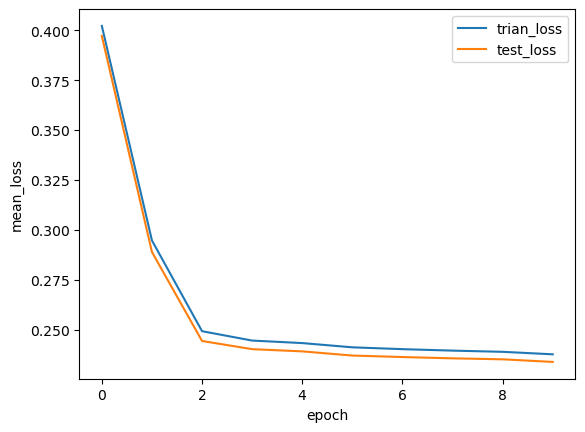

In [5]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.20540967215896763
test loss is 0.2337918046060831
Batch: 100,train loss is: 0.2840256845566676
test loss is 0.23419192347105203
Batch: 200,train loss is: 0.2526451919400101
test loss is 0.23366061433860053
Batch: 300,train loss is: 0.2684950469050086
test loss is 0.23499749601598666
Batch: 400,train loss is: 0.2761712798066956
test loss is 0.23568910269033735
Batch: 500,train loss is: 0.28517448163426434
test loss is 0.23440082199329712
Batch: 600,train loss is: 0.27364870843372285
test loss is 0.2342111820848113
Batch: 700,train loss is: 0.22868988530799111
test loss is 0.23342262991955678
Batch: 800,train loss is: 0.21288881995823844
test loss is 0.23338019006917834
Batch: 900,train loss is: 0.24338253083113776
test loss is 0.23359470930448323
Batch: 1000,train loss is: 0.2542711276653563
test loss is 0.233619111803706
-----------------------Epoch: 1----------------------------------
Batch: 0,

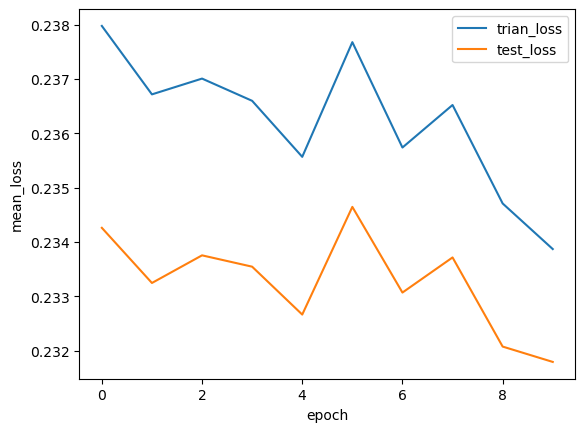

In [6]:
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,10)